In [3]:
import numpy as np
import pandas as pd
from bucketing import Create3Buckets
from CTN import CN, CTN
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
url = 'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv'
df = pd.read_csv(url, parse_dates=['date']).dropna().reset_index(drop=True)
df['margin'] = np.abs(df['score1'] - df['score2'])
df['spi_margin'] = np.abs(df['spi1'] - df['spi2'])
df['H'] = df['spi1']
df['A'] = df['spi2']
spi_m = df['spi_margin']
spi_m_b = Create3Buckets(spi_m,np.percentile(spi_m,(100/3)),np.percentile(spi_m,(200/3)),"Close Game","Moderate Favorite","Clear Favorite","spi_margin_bucket")
df = pd.concat([df,spi_m_b],axis=1)
t1 = CN(df,"team1")
t2 = CN(df,"team2")
sm = CN(df,"spi_margin_bucket")
team1 = CTN(df,4,5,t1)
team2 = CTN(df,5,6,t2)
spi_margin = CTN(df,27,28,sm)
X_num = df[['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'importance1', 'importance2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2', 'adj_score1', 'adj_score2', 'margin', 'spi_margin']].reset_index(drop=True)
X_final = pd.concat([team1, team2, spi_margin, X_num], axis=1)
y_final = df[['league']].copy()
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.375, random_state=6)

In [4]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
models = []
models.append(('BC:', BaggingClassifier()))
models.append(('RFC:', RandomForestClassifier()))
models.append(('ETC:', ExtraTreesClassifier()))
# models.append((':', ()))
names = []
results = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=6, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring='accuracy')
    names.append(name)
    results.append(cv_results)
    print("%s %f (%f)" % (name, cv_results.mean(), cv_results.std()))

BC: 0.721324 (0.013360)
RFC: 0.845487 (0.009692)
ETC: 0.916272 (0.004703)


In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
model = ExtraTreesClassifier().fit(X_train, y_train.values.ravel())
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test_pred, y_test))
print("Classification Report:", classification_report(y_test_pred, y_test))
print("Confusion Matrix:", confusion_matrix(y_test_pred, y_test))

Accuracy Score: 0.9226535772720512
Classification Report:                                           precision    recall  f1-score   support

              Argentina Primera Division       0.99      0.91      0.95       353
                     Australian A-League       0.89      1.00      0.94        64
                 Barclays Premier League       0.98      0.92      0.95       648
                      Brasileiro Série A       0.99      0.98      0.98       425
                    Chinese Super League       0.89      0.98      0.93       118
                        Dutch Eredivisie       0.51      0.96      0.67        23
             English League Championship       0.99      0.94      0.96       591
                          French Ligue 1       0.99      0.96      0.97       608
                    German 2. Bundesliga       0.98      0.96      0.97       310
                       German Bundesliga       0.99      0.93      0.96       529
                           Italy Serie 

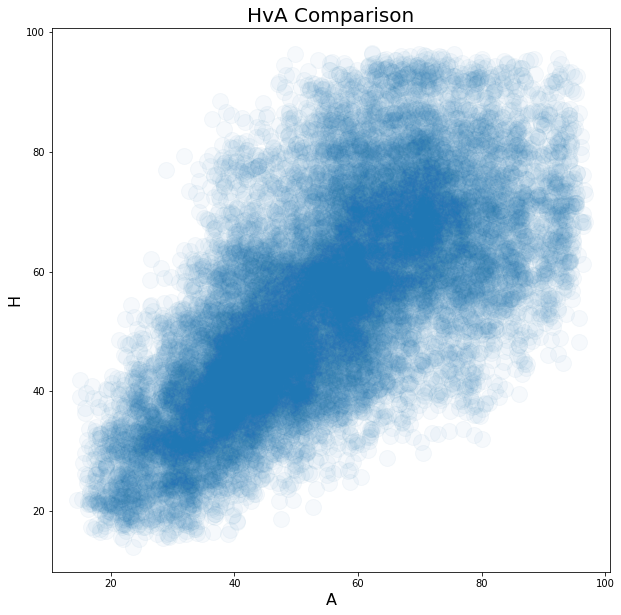

In [15]:
import matplotlib.pyplot as plt
plt.plot(df['A'],df['H'],"o",alpha=0.04,markersize=16)
plt.title("HvA Comparison", fontsize=20)
plt.xlabel("A", fontsize=16)
plt.ylabel("H", fontsize=16)
plt.rcParams['figure.figsize'] = (10,10)
plt.show()